# Tutorial #2: Logistic Regression

In this tutorial, we'll explain logistic regression and use it for classification of a few simple datasets. In logistic regression, the goal is to classify a datapoint into one of two or more classes. The data is given by inputs $\boldsymbol{x}_i \in \mathbb{R}^d$, while the classes are described by the output $y_i$ (for binary logistic regression) or a one-hot vector $\boldsymbol{y}_i$ (for multi-class logistic regression).

### Binary logistic regression

Let's assume that the output variable $y \in [0, 1]$ is a binary variable representing one of two classes, while the input variable $\boldsymbol{x}$ represents the features of the datapoint.  The logistic regression model outputs an estimate of the probability $\hat{y}$ that the datapoint falls into class 1. This means that the datapoint is in class $y=1$ with probability $\hat{y}$ and class $y=0$ with probability $1-\hat{y}$. Thus, $$p(y|\hat{y}) = \hat{y}^y(1-\hat{y})^{1-y}.$$ 
Logistic regression models output a linear function of the inputs, so that $$z = \boldsymbol{w}^T \boldsymbol{x}.$$ (Once again, we've hidden the bias term $b$ in this dot product by appending a dummy node with value 1 to $\boldsymbol{x}$, so that $\boldsymbol{w} \in \mathbb{R}^{d+1}$.) However, the probability $\hat{y}$ must be between 0 and 1. To ensure that $\hat{y}$ falls between 0 and 1, we set $\hat{y} = \sigma({z})$ where $\sigma$ is the logistic function $$\sigma(z) = \frac{e^z}{1+e^z} = \frac{1}{1+e^{-z}}.$$ Note that $\sigma(z \rightarrow \infty) = 1$ and $\sigma(z \rightarrow -\infty) = 0$. This gives $$p(y|\boldsymbol{x}, \boldsymbol{w}) = \sigma(\boldsymbol{w}^T \boldsymbol{x})^y(1-\sigma(\boldsymbol{w}^T \boldsymbol{x}))^{1-y}.$$ We then maximize the log probability of the data, which is equivalent to minimizing a loss function given by the negative log probability of the data. For a dataset with $N$ examples $\{\boldsymbol{x}_{i}, {y}_i\}_{i=1}^N$, the logistic regression loss function is the cross-entropy loss $$L = -\sum_{i=1}^N \big[y_i \log{\sigma(\boldsymbol{w}^T\boldsymbol{x}_i)} +(1-y_i)\log{(1-{\sigma(\boldsymbol{w}^T\boldsymbol{x})})}\big].$$
Note that the variable $z$ is called a logit, and ranges from $z \in [-\infty,\infty]$. This is because the logit function is the inverse of the logistic function, so $z = \sigma^{-1}(\hat{y})$. 

### Multi-class logistic regression

We can generalize binary logistic regression to multi-class logistic regression in a straightforward way. Now, the output variable $\boldsymbol{y}_i \in \mathbb{R}^K$ is a one-hot vector representing which of the $K$ classes the datapoint is in. Instead of outputting one linear function $z$, the multi-class logistic regression model outputs $K$ linear functions $$\boldsymbol{z} = \boldsymbol{W} \boldsymbol{x}$$
where $\boldsymbol{W} \in \mathbb{R}^{K \times (d+1)}$. To convert the logits $\boldsymbol{z}$ into a probability, we replace the Logistic function with the Softmax function $$\sigma(\boldsymbol{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}.$$ The cross-entropy loss function is replaced with $$L = -\sum_{k=1} y_k \log{p(y_k|\boldsymbol{x})} = -\log{p(y_c|\boldsymbol{x})}$$ where $c$ is the correct class. 

Useful references on Logistic Regression:
* [COS324](https://www.cs.princeton.edu/courses/archive/spring19/cos324/) Princeton lecture notes, [Logistic Regression](https://www.cs.princeton.edu/courses/archive/spring19/cos324/files/logistic-regression.pdf)
* [Probabilistic Machine Learning Book](https://probml.github.io/pml-book/book1.html) (Kevin Murphy), Chapter 10
* Stanford textbook [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/) (Daniel Jurafsky and James H. Martin), Chapter 5

We'll begin by performing logistic regression analytically using a synthetic dataset for a single scalar variable and binary outcomes, then we'll use `scikit-learn` and `flax` to perform logistic regression on a multivariate dataset with binary outcomes.

### 2.1: Analytic Logistic Regression using `jax.numpy` and synthetic data

We'll first generate some synthetic data. We'll have two classes which are not linearly separable.

In [1]:
import jax.numpy as jnp
import jax.random as random
import jax
import matplotlib.pyplot as plt

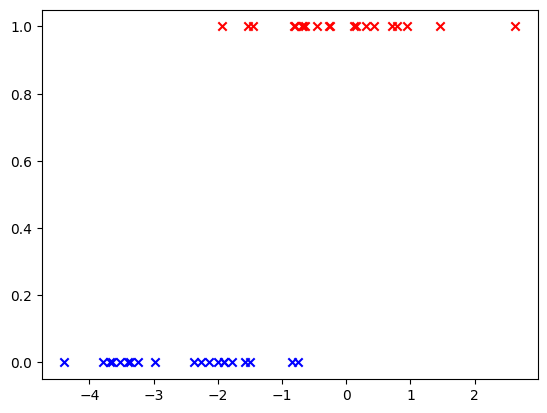

In [2]:
key = random.key(0)
N_data = 40

def class_1(key, N):
    return -2.5 + random.normal(key, (N,))

def class_2(key, N):
    return 0.5 + random.normal(key, (N,))

key1, key2 = random.split(key)

x_1 = class_1(key1, N_data//2)
x_2 = class_2(key2, N_data//2)

y_1 = jnp.zeros(x_1.shape)
y_2 = jnp.ones(x_2.shape)

plt.scatter(x_1, y_1, color='blue', marker='x')
plt.scatter(x_2, y_2, color='red', marker='x')
plt.show()

We'll then assume that our data is given by a logistic regression model, with $p(y = 1 | x) = \sigma(z)$ with $z = w x + b$.

In [3]:
X = jnp.concatenate([x_1, x_2])
Y = jnp.concatenate([y_1, y_2])

def logistic(z):
    return 1 / (1 + jnp.exp(-z))

def loss_function(x, y, w, b):
    z = x * w + b
    return -y * jnp.log(logistic(z)) - (1-y) * jnp.log(1 - logistic(z))

loss_grad_fn = jax.value_and_grad(jax.jit(lambda w, b: jnp.mean(jax.vmap(loss_function, in_axes=(0,0,None,None), out_axes=0)(X, Y, w, b))), argnums=(0, 1))

In [4]:
key, subkey = random.split(key)
w_init = random.normal(subkey)
b_init = 0.0
N_train = 100000
lr = 1e-3
losses = []

w = w_init
b = b_init
for _ in range(N_train):
    loss, grads = loss_grad_fn(w, b)
    losses.append(loss)
    w = w - lr * grads[0]
    b = b - lr * grads[1]
print(w)
print(b)

2.3281345
2.9657009


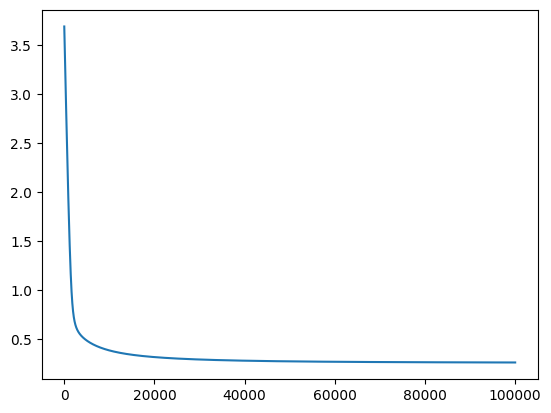

In [5]:
plt.plot(losses)
plt.show()

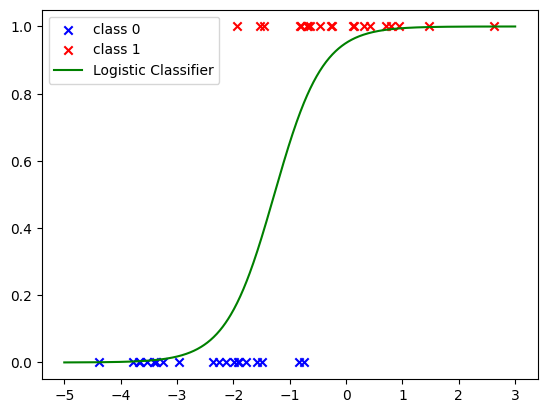

In [6]:
plt.scatter(x_1, y_1, color='blue', marker='x',label='class 0')
plt.scatter(x_2, y_2, color='red', marker='x', label='class 1')
x_plot = jnp.linspace(-5.0, 3.0, 1000)
plt.plot(x_plot, logistic(x_plot * w + b), color='green',label='Logistic Classifier')
plt.legend()
plt.show()

### 3.2: Scikit-learn for multivariate dataset

For our multivariate dataset, we'll use a breast cancer diagnostic dataset with 568 individuals and 30 features per individual. We can read in the data into a pandas dataframe. We'll then separate the data into training and testing splits, with 80% of the data in the training set and 20% in the testing set. Since our data has no temporal state, we can split the training and testing data by sampling randomly without introducing data leakage.

In [7]:
import pandas as pd

df = pd.read_csv('datasets/breast_cancer_wisconsin/wdbc.data')
dataset = df.to_numpy()
X = jnp.asarray(dataset[:,2:].astype(float))
y = jnp.asarray((dataset[:,1] == 'B').astype(int))

key = random.key(0)
key, subkey = random.split(key)
X_shuffled = random.permutation(subkey, X, axis=0)
y_shuffled = random.permutation(subkey, y, axis=0)

N_div = int(0.8 * X.shape[0])
X_train = X_shuffled[:N_div]
y_train = y_shuffled[:N_div]
X_test = X_shuffled[N_div:]
y_test = y_shuffled[N_div:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(454, 30)
(454,)
(114, 30)
(114,)


Next we can use sklearn to perform logistic regression. With the `.fit()` function we can train a model, and with the `.score()` function we can evaluate performance on the testing dataset.

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', max_iter=10000)
trained_model = model.fit(X_train, y_train)

print(trained_model.coef_)
print(trained_model.intercept_)

[[ 0.87870757  0.2069431  -0.3701222   0.03394358 -0.14405206 -0.20027823
  -0.46687575 -0.26284592 -0.14658547 -0.03665695 -0.11164357  1.02741468
   0.49204134 -0.15826768 -0.01646533  0.03437384 -0.03764003 -0.02524057
  -0.00926124  0.00285097 -0.03401479 -0.48492786 -0.12485884 -0.01277417
  -0.30292569 -0.56487736 -1.20251677 -0.50044586 -0.40225317 -0.09490903]]
[36.8838356]


By the way, we could have also imported the dataset from the `sklearn` library, using `from sklearn.datasets import load_breast_cancer` and
`data = load_breast_cancer()` with `X = data.data` and `y = data.target`.

We'll now evaluate model performance using the test dataset.

In [9]:
trained_model.score(X_test, y_test)

0.9385964912280702

We get about 93.8% accuracy.

### 3.3: `flax` for multivariate binary classification with logistic regression

We'll first write a logistic regression model in `flax`.

In [10]:
from flax import nnx
import optax

class LogisticRegression(nnx.Module):
    def __init__(self, din: int, rngs: nnx.Rngs):
        self.linear = nnx.Linear(din, 1, rngs=rngs)

    @staticmethod
    def logistic(z):
        return 1 / (1 + jnp.exp(-z))

    def __call__(self, x):
        return self.linear(x)

In [11]:
rngs = nnx.Rngs(0)
model = LogisticRegression(X.shape[1], rngs=rngs)
optimizer = nnx.Optimizer(model, optax.sgd(1e-3))

In [12]:
@nnx.jit
def train_step(model, optimizer, X_train, y_train):
    def loss_fn(model):
        z = model(X_train)
        y_hat = model.logistic(z)[...,0]
        return jnp.mean(- y_train * jnp.log(y_hat) - (1 - y_train) * jnp.log(1 - y_hat))

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

In [13]:
loss = train_step(model, optimizer, X_train, y_train)
print(loss)

nan


Oh no! Our loss function is giving us `NaN`s. The culprit is the `logistic` function, which gives zeros for small values of `z`. Since all the $\hat{y}$ are zero, then the log-probabilities are all NaN.

In [14]:
z = model(X_train)
print(z.shape)
print(z[0:10,0])
print(logistic(z)[0:10,0])

(454, 1)
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]


We'll have to find a way to eliminate `NaN`s from the loss function. To do so, we'll normalize our data.

#### 3.3.1: Normalize data

Typically, machine learning models work better if the dataset has a mean of zero and a standard deviation of 1. For logistic regression, they are also more numerically stable. For each feature (in both the training and testing sets), we'll perform z-score normalization by subtracting by the mean of the training data and dividing by the standard deviation of the training data.

In [15]:
means = jnp.mean(X_train, axis=0)
stds = jnp.std(X_train, axis=0)

X_train_normalized = (X_train - means) / stds
X_test_normalized = (X_test - means) / stds

Now let's try computing the loss function with the normalized data.

In [16]:
rngs = nnx.Rngs(0)
model = LogisticRegression(X.shape[1], rngs=rngs)
optimizer = nnx.Optimizer(model, optax.sgd(1e-3))

In [17]:
loss = train_step(model, optimizer, X_train_normalized, y_train)
print(loss)
loss = train_step(model, optimizer, X_train_normalized, y_train)
print(loss)

0.7212271
0.71916074


In [18]:
losses = []
N_train = 50000
for _ in range(N_train):
    loss = train_step(model, optimizer, X_train_normalized, y_train)
    losses.append(loss)

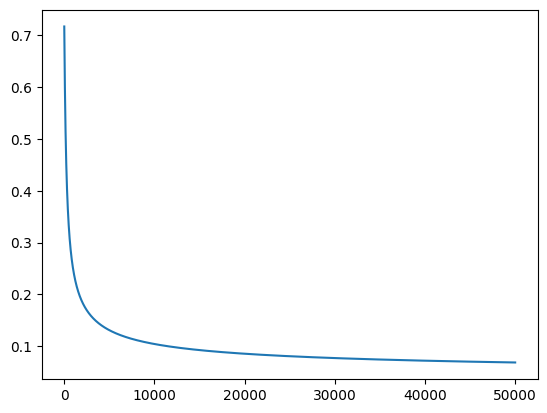

In [19]:
plt.plot(losses)
plt.show()

We'll now evaluate the performance of the trained model.

In [20]:
y_hat_test = model(X_test_normalized)[:,0]
y_test_eval = (y_hat_test > 0.5).astype(int)
accuracy = jnp.mean((y_test == y_test_eval).astype(int))
print(accuracy)

0.94736844


We get 94.7% accuracy on the test dataset.